# 9. Simulation

**Objective:**

Testing and comparison of the performance of various methods of Gaussian process feature selection for sparse datasets. 

**Models:**

1. Standard optimization

2. ARD kernel optimization

3. Lasso feature selection before optimization
    - $\lambda$ selected via cross-validation
4. Lasso feature selection before ARD kernel optimization
    - $\lambda$ selected via cross-validation
5. L1-penalized optimization
    - $\lambda$ selected via cross-validation
    - Includes added thresholding


**Metrics:**

Three metrics will be used to compare the performance of the 5 models. 

- Estimation error of coefficients $$\varepsilon_{\beta} = \|\beta - \hat{\beta}\|_2$$
- Prediction error $$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}\left(y_i - \hat{y_i}\right)^2}$$
- Computation Time:
    - Total runtime for model fitting, training, and prediction, measured in seconds.

### Testing on one dataset

In [81]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gpflow as gpf
import json
import tensorflow as tf
import time

from sklearn.linear_model import LinearRegression, LassoLarsCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Define a class


In [123]:
class GPFeatureSelect:

    def __init__(self, model_type = 'std', cv = 5):
        self.model_type = model_type
        self.cv = cv

        self.scaler = StandardScaler()
        self.scaledX = None
        self.selected_features = None
        self.lasso_model = None
        self.lambda_val = None
        self.beta_hat = None
        self.runtime = None
        self.opt = gpf.optimizers.Scipy()
        
    def training_loss_lasso(self):
        base_loss = self.gp_model.training_loss()
        l1_penalty = self.lambda_val * tf.reduce_sum(tf.abs(self.gp_model.mean_function.A))
        total_loss = base_loss + l1_penalty
        return total_loss

    def cv_lasso_lars(self, X, y):
        if self.model_type in ['lasso_std', 'lasso_ard']:
            las = LassoLarsCV(cv = self.cv)
            las.fit(X, y.ravel())
            mask = np.abs(las.coef_) > 1e-4
            self.selected_features = np.where(mask)[0]
            self.beta_hat = las.coef_
            self.lasso_model = las
            self.lambda_val = las.alpha_
            return X[:, self.selected_features]
            
        else:
            raise ValueError("cv_lasso_lars called on non-lasso model")

    def tune_lambda(self, X, y):
        def run_cv(lambda_grid):
            best_lbda = None
            best_rmse = np.inf
            lambda_rmse_pairs = []

            for l in lambda_grid:
                rmses = []
                kf = KFold(n_splits=self.cv, shuffle=True, random_state=22)
                for train_index, val_index in kf.split(X):
                    X_train, X_val = X[train_index], X[val_index]
                    y_train, y_val = y[train_index], y[val_index]

                    self.init_ard_gp_mod(X_train, y_train)
                    self.lambda_val = l
                    self.opt.minimize(
                        lambda: self.training_loss_lasso(),
                        self.gp_model.trainable_variables
                    )

                    y_pred = self.gp_model.predict_f(X_val)[0].numpy().flatten()
                    rmse = np.sqrt(np.mean((y_val - y_pred) ** 2))
                    rmses.append(rmse)

                avg_rmse = np.mean(rmses)
                lambda_rmse_pairs.append((l, avg_rmse))

                #print('\nRMSE for this fold: ', avg_rmse)

                if avg_rmse < best_rmse:
                    best_rmse = avg_rmse
                    best_lbda = l

            return best_lbda, lambda_rmse_pairs

        coarse_grid = np.logspace(-1, 1, 10)
        #print("Coarse grid:", coarse_grid)

        best_coarse, coarse_log = run_cv(coarse_grid)
        #print("Best coarse λ:", best_coarse)
        return best_coarse

        # fine_grid = np.linspace(best_coarse * 0.5, best_coarse * 1.5, 10)
        # best_fine, fine_log = run_cv(fine_grid)
        # self.lambda_val = best_fine
        # self.lambda_rmse_log = coarse_log + fine_log
        #return best_fine

        
    def init_gp_mod(self, X, y):
        y = np.asarray(y).reshape(-1, 1)
        m = X.shape[1]
        A_init = tf.zeros((m, 1), dtype=tf.float64)
        b_init = tf.zeros((1,), dtype=tf.float64)

        kernel = gpf.kernels.SquaredExponential(lengthscales=1)
        likelihood = gpf.likelihoods.Gaussian()
        mean_function = gpf.mean_functions.Linear(A=A_init, b = b_init) 

        self.gp_model = gpf.models.GPR(data = (X, y.reshape(-1,1)), kernel = kernel, likelihood = likelihood, mean_function = mean_function)

    def init_ard_gp_mod(self, X, y):
        y = np.asarray(y).reshape(-1, 1)
        m = X.shape[1]
        A_init = tf.zeros((m, 1), dtype=tf.float64)
        b_init = tf.zeros((1,), dtype=tf.float64)

        kernel = gpf.kernels.SquaredExponential(lengthscales=np.ones(m))
        likelihood = gpf.likelihoods.Gaussian()
        mean_function = gpf.mean_functions.Linear(A=A_init, b = b_init) 

        self.gp_model = gpf.models.GPR(data = (X, y.reshape(-1,1)), kernel = kernel, likelihood = likelihood, mean_function = mean_function)

    def fit(self, X, y):

        #start_time = time.time()

        X = self.scaler.fit_transform(X)
        y = np.asarray(y).reshape(-1,1)

        if self.model_type == 'std':
            self.init_gp_mod(X, y)
            self.opt.minimize(
                self.gp_model.training_loss,
                self.gp_model.trainable_variables)
            self.beta_hat = self.gp_model.mean_function.A.numpy().flatten()

        elif self.model_type =='ard':
            self.init_ard_gp_mod(X, y)
            self.opt.minimize(
                self.gp_model.training_loss,
                self.gp_model.trainable_variables)
            self.beta_hat = self.gp_model.mean_function.A.numpy().flatten()

        elif self.model_type =='lasso_std':
            reducedX = self.cv_lasso_lars(X,y)
            self.init_gp_mod(reducedX, y)
            self.opt.minimize(
                self.gp_model.training_loss,
                self.gp_model.trainable_variables)
            self.beta_hat = self.gp_model.mean_function.A.numpy().flatten()
            
        elif self.model_type == 'lasso_ard':
            reducedX = self.cv_lasso_lars(X,y)
            self.init_ard_gp_mod(reducedX, y)
            self.opt.minimize(
                self.gp_model.training_loss,
                self.gp_model.trainable_variables)
            self.beta_hat = self.gp_model.mean_function.A.numpy().flatten()

        elif self.model_type == 'l1_gp': 
            if self.lambda_val is None:
                self.tune_lambda(X,y)

            # start by training on all features
            self.init_ard_gp_mod(X, y)
            self.opt.minimize(
                lambda: self.training_loss_lasso(),
                self.gp_model.trainable_variables   
            )

            # threshold coefficients to select features
            beta_full = self.gp_model.mean_function.A.numpy().flatten()
            threshold = 1e-2  ###
            mask = np.abs(beta_full) > threshold

            ### CHECK THIS
            beta_full[~mask] = 0.0

            self.beta_hat = beta_full[mask]
            self.selected_features = np.where(mask)[0]

            # if len(self.selected_features) == 0:
            #     print ('No features selected after thresholding')
            #     return
            
            # # retrain on selected features
            # X_reduced = X[:, self.selected_features]
            # self.init_ard_gp_mod(X_reduced, y)
            # self.opt.minimize(
            #     lambda: self.training_loss_lasso(),
            #     self.gp_model.trainable_variables)
            
            # # update beta_hat 
            # self.beta_hat = self.gp_model.mean_function.A.numpy().flatten()

        else:
            raise ValueError("Unknown model type")
        
    def predict(self, X):
        X = self.scaler.transform(X)
        if self.selected_features is not None:
            if isinstance(X, pd.DataFrame):
                X = X.iloc[:, self.selected_features]
            else:
                X = X[:, self.selected_features]

        X = np.asarray(X)
        mean, _ = self.gp_model.predict_f(X)
        return mean.numpy().flatten()
    
    def get_metrics(self, Xtest, ytest, beta_true=None):
        y_pred = self.predict(Xtest)
        rmse = np.sqrt(np.mean((ytest - y_pred) ** 2))
        beta_error = None
        if beta_true is not None and self.beta_hat is not None:
            if self.selected_features is not None:
                beta_error = np.linalg.norm(beta_true[self.selected_features] - self.beta_hat)
            else:
                beta_error = np.linalg.norm(beta_true - self.beta_hat)
        return {
            'rmse': rmse,
            'beta_error': beta_error,
            'runtime': self.runtime
        }
         

## Testing each model using one simulated dataset

In [83]:
data_path = 'Simulation Datasets/N1000_AP10_seed30/N1000_AP10_seed30_data.csv'
meta_path = 'Simulation Datasets/N1000_AP10_seed30/N1000_AP10_seed30_meta.json'

In [85]:
with open(meta_path, 'r') as f:
    meta = json.load(f)

beta_true = np.array(meta['beta'])

beta_true.argmin()

23

{'n': 1000, 'active_prop': 0.1, 'seed': 30, 'active_indices': [29, 23, 10], 'gp_features': [10, 23, 29], 'lengthscales': [0.8698169496364162, 0.9804929866874791, 0.4304293593749552], 'beta': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.14306991340722863, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -4.482965427009537, 0.0, 0.0, 0.0, 0.0, 0.0, 0.42388484671118665]}
24.701479589232694


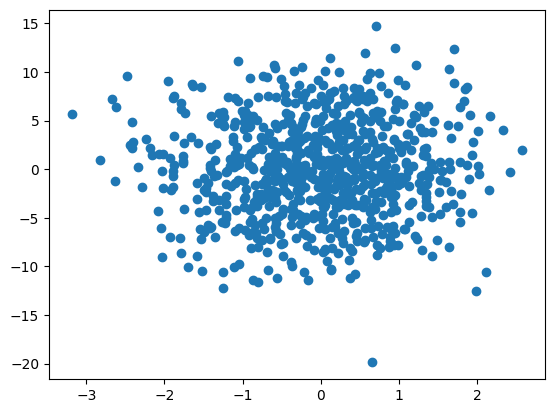

In [109]:
dat = pd.read_csv(data_path)
dat.head()
X = dat.drop(columns = 'y')
y = dat['y']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state = 22)

print(meta)

import matplotlib.pyplot as plt
plt.scatter(Xtrain.iloc[:, 1], ytrain)

print(np.var(ytrain))

In [96]:
mod1_std = GPFeatureSelect(model_type='std')
mod1_std.fit(Xtrain,ytrain)
mod1_std.get_metrics(Xtest, ytest, beta_true)

{'rmse': 1.4678241977454105, 'beta_error': 0.409910811454901, 'runtime': None}

In [97]:
mod2_ard = GPFeatureSelect(model_type = 'ard')
mod2_ard.fit(Xtrain, ytrain)
mod2_ard.get_metrics(Xtest, ytest, beta_true)

{'rmse': 1.4678242974598465,
 'beta_error': 0.40991058419664683,
 'runtime': None}

In [98]:
mod3_las_std = GPFeatureSelect(model_type = 'lasso_std')
mod3_las_std.fit(Xtrain, ytrain)
mod3_las_std.get_metrics(Xtest, ytest, beta_true)


{'rmse': 1.4654936328474515,
 'beta_error': 0.37214117231477783,
 'runtime': None}

In [99]:
print(mod3_las_std.lambda_val)

0.06848557179489526


In [100]:
mod4_las_ard = GPFeatureSelect(model_type = 'lasso_ard')
mod4_las_ard.fit(Xtrain, ytrain)
mod4_las_ard.get_metrics(Xtest, ytest, beta_true)

{'rmse': 1.4457837577451293,
 'beta_error': 0.24527972598151362,
 'runtime': None}

In [115]:
mod4_las_ard.beta_hat

array([-0.13170553, -4.62092828,  0.04052219,  0.22549836])

In [101]:
print(mod4_las_ard.lambda_val)

0.06848557179489526


In [124]:
mod5_l1_gp = GPFeatureSelect(model_type = 'l1_gp')
mod5_l1_gp.fit(Xtrain, ytrain)
mod5_l1_gp.get_metrics(Xtest, ytest, beta_true)

mod5_l1_gp.beta_hat

ShapeMismatchError: 
Tensor shape mismatch.
  Function: Kernel.__call__
    Declared: /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpflow/kernels/base.py:188
    Argument: X
      Expected: [batch..., N, D]
      Actual:   [800, 30]
    Argument: X2
      Expected: [batch2..., N2, D]
      Actual:   [200, 11]


In [122]:
mod5_l1_gp.beta_hat

array([-0.01126588,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.03666538,  0.        ,  0.        ,
       -0.12438167,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.02167382,  0.        ,  0.02636785, -0.04373428,  0.        ,
        0.        ,  0.        ,  0.        , -4.70129325,  0.0469446 ,
       -0.01208415,  0.0148248 ,  0.        ,  0.        ,  0.13071189])

In [103]:
print(mod5_l1_gp.lambda_val) # ask about this

10.0
